# Tutorial on regexmodel

## Setup and installation

If you haven't installed `regexmodel` yet, including the optional dependencies, do so now:

In [1]:
# %pip install git+https://github.com/sodascience/regexmodel.git[tutorial]

Normally we would already have data that we want to model and synthesize, but for this tutorial we will use the faker package to generate that data for us. We will use fake email addresses.

In [2]:
from faker import Faker
from regexmodel.util import Dir
from regexmodel.datastructure import BaseRegex
from regexmodel.model import RegexModel
from regexmodel.datastructure import RegexNode, OrNode, Edge
import polars as pl

fake = Faker("nl")
Faker.seed(12345)
email_addresses = pl.Series([fake.mime_type() for _ in range(40)])
series = email_addresses

In [3]:
model = RegexModel.fit(email_addresses, count_thres=3)
print(model.fit_statistics(email_addresses))
print(model.regex_edge.count_list, model.regex)

{'failed': 9, 'success': 31, 'n_tot_char': 580, 'n_char_success': 419, 'n_parameters': 11, 'avg_log_like_per_char': -4.29603283252874, 'avg_log_like_pc_success': -3.29248315739987}
[31, 31, 31, [[27], [4, 4, 4, 4, 4]], 0] [mata-z]{4,11}[/][a-z]{2,10}(|[\+][x][m][l])


In [4]:
model.serialize()

Regex <[mata-z]{4,11}> [31, 31, 31, [[27], [4, 4, 4, 4, 4]], 0]
Regex <[/]> [31, 31, [[27], [4, 4, 4, 4, 4]], 0]
Regex <[a-z]{2,10}> [31, [[27], [4, 4, 4, 4, 4]], 0]
OrNode <(|[\+][x][m][l])> -> <> [[[27], [4, 4, 4, 4, 4]], 0]
Regex <[\+]> [4, 4, 4, 4, 4]
Regex <[x]> [4, 4, 4, 4]
Regex <[m]> [4, 4, 4]
Regex <[l]> [4, 4]


('[mata-z]{4,11}[/][a-z]{2,10}(|[\\+][x][m][l])',
 [31, 31, 31, [[27], [4, 4, 4, 4, 4]], 0])

In [5]:
from regexmodel.regexclass import OrRegex, LiteralRegex

OrRegex.from_string(r"[ab\]cA-Za-z0-9]")
# LiteralRegex.from_string(r"\]")

(OrRegex[ab\]cA-Za-z0-9], '')

In [6]:
import re
from regexmodel.regexclass import LowerRegex, UpperRegex, DigitRegex, LiteralRegex, ALL_REGEX_CLASS

print(re.match(r"\\]", r"\]"))

rex = r"^\[([\S\s]*?[^\\])\]"
options = re.search(rex, r"[ab\]cA-Za-z0-9]").group(1)

options

<re.Match object; span=(0, 2), match='\\]'>


'ab\\]cA-Za-z0-9'

In [7]:
[model.draw() for _ in range(10)]

['opxc/vhhdtoi',
 'znfz/dsdrcb',
 'abrldtobtap/bum',
 'togqorooqbe/zocqarvxj+xml',
 'pmrv/wudes',
 'igtcrzefkj/qorldxdpyc',
 'lpxrzatmup/pk+xml',
 'mfamqedddt/tstwrhshdf',
 'ahfk/sszeeasu',
 'idowlipjgmn/zqp']

In [8]:
import json
with open("../scripts/data/benchmark.json") as handle:
    bench_data = json.load(handle)
with open("../scripts/data2/benchmark.json") as handle:
    bench_data_new = json.load(handle)

In [9]:
import numpy as np
from matplotlib import pyplot as plt

def _get_success_rate(fake_type, bench_data):
    n_param = []
    success = []
    fails = []
    # for var_data in bench_data.values():
    for data in bench_data[fake_type].values():
        n_param.extend(x["n_parameters"] for x in data)
        success.extend(x["success"] for x in data)
        fails.extend(x["failed"] for x in data)

    success_rate = np.array(success)/(np.array(fails)+np.array(success))
    return np.array(n_param), success_rate

def plot_succes_rate(fake_type):
    plt.scatter(*_get_success_rate(fake_type, bench_data), label="old")
    plt.scatter(*_get_success_rate(fake_type, bench_data_new), label="new")
    plt.legend()
    plt.show()

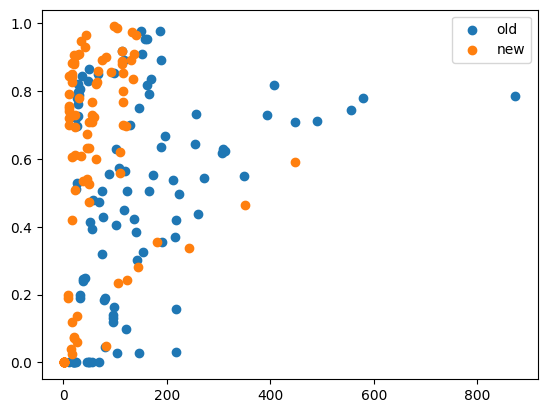

In [10]:
plot_succes_rate("address")

In [11]:
for url in email_addresses[:10]:
    print(url, list(model.regex_edge.log_likelihood(url)))

text/cmd [('d', -24.400192853485734), ('', -27.658289391507218)]
model/x3d+xml []
multipart/alternative [('ternative', -41.23667200341811), ('ernative', -44.49476854143959), ('rnative', -47.752865079461074), ('native', -51.01096161748255), ('ative', -54.269058155504034), ('tive', -57.52715469352552), ('ive', -60.785251231546994), ('ve', -64.04334776956848), ('e', -67.30144430758997)]
model/x3d+binary []
text/csv [('v', -24.400192853485734), ('', -27.658289391507218)]
multipart/mixed [('xed', -41.23667200341811), ('ed', -44.49476854143959), ('d', -47.752865079461074), ('', -51.01096161748255)]
text/javascript [('vascript', -24.400192853485734), ('ascript', -27.658289391507218), ('script', -30.916385929528698), ('cript', -34.17448246755018), ('ript', -37.43257900557166), ('ipt', -40.690675543593144), ('pt', -43.94877208161462), ('t', -47.20686861963611), ('', -50.464965157657595)]
image/svg+xml [('g+xml', -27.76748868347221), ('+xml', -31.025585221493692), ('', -32.93512772637813)]
image

In [12]:

def create_regex_from_list(regex_data):
    if isinstance(regex_data, BaseRegex):
        return regex_data.regex
    if isinstance(regex_data, tuple):
        optional_regex = [create_regex_from_list(rx) for rx in regex_data]
        return r"(" + r"|".join(optional_regex) + ")"
    return "".join(create_regex_from_list(rx) for rx in regex_data)



## Modeling the structured strings

Now we will use the regexmodel package to model the data:

In [13]:
    # while cur_series.drop_nulls().len() > count_thres:
        
    # if result["score"] < count_thres/len(series):
    #     return [], []
    # regex_list, count_list = fit_main_branch(result["new_series"], count_thres=count_thres,
    #                                          direction=direction)
    # n_main_line = result["new_series"].drop_nulls().len()
    # n_alt_line = result["alt_series"].drop_nulls().len()
    # regex_list = [result["regex"]] + regex_list
    # count_list = [n_main_line] + count_list

    # if len(result["alt_series"].drop_nulls()) > count_thres and optionals:

    #     regex_main = "".join(rx.regex for rx in regex_list)
    #     res = result["alt_series"].str.extract(r"(^[\S\s]*?)" + regex_main + r"$")
    #     alt_regex_list, alt_count_list = fit_main_branch(res, count_thres, direction)
    #     if len(alt_regex_list) > 0:
    #         regex_list = [(alt_regex_list, [])] + regex_list
    #         count_list = [(alt_count_list[-1], n_main_line)] + count_list

    # return return_links
    # # return regex_list, count_list


In [14]:
from regexmodel import RegexModel

model = RegexModel.fit(email_addresses)

Let's first see how the good the model is by synthesizing new email addresses:

In [15]:
[model.draw() for _ in range(10)]

['azjbxytt/cpgsvpgyb',
 'helnkon/zbwiaqf',
 'ctsrgce/ipdl',
 'ikfmm/wzuj',
 'pmlmhwdu/nnshachm',
 'wsixmqksdkt/xhruih',
 'latbgmmmy/dbzs+xml',
 'peiyr/cdmptydd',
 'ytxf/qr',
 'imbamhxjjzd/nb+xml']

While certainly not perfect, it certainly isn't so bad either, given that we have given the model only positive examples!

Now let's look at the serialization of the model:

In [16]:
model.serialize()

{'regex': '[mata-z]{4,11}[/][a-z]{2,10}(|[\\+][x][m][l])',
 'counts': [31, 31, 31, [[27], [4, 4, 4, 4, 4]], 0]}

The serialization might seem overwhelming at first, but the first regex (`[a-z]{3,18}[0-9]{2,2}[@][a-z]{4,9}[\\\\.][c][o][m]`) is usually the most important one. We call this the main branch. On this main branch, there will be side branches, for example for ".info" and ".biz" email addresses.

## Modeling performance

There are also some modeling statistics that can be computed. Note that computing these can take a while depending on your computer.

In [17]:
model.fit_statistics(email_addresses)

{'failed': 9,
 'success': 31,
 'n_tot_char': 580,
 'n_char_success': 419,
 'n_parameters': 11,
 'avg_log_like_per_char': -4.29603283252874,
 'avg_log_like_pc_success': -3.29248315739987}

What the `fit_statistics` method does is to retrace back whether an email address that is given to it (e.g. johndoe@example.com) has a non-zero probability to be generated by the regex model. As we can see above, there were 18 email addresses in the list that have a probability of 0 to be generated by the model, while the overwhelming majority (982) can be generated with the fitted model.

The value `n_parameters` gives the number of nodes in the model, and is thus an indicator of the complexity of the model. This is also correlated with the fit taking longer. We can influence this parameter during fitting by setting the `count_thres` parameter. If we set that threshold higher, we generally have a lower number of parameters and better performance.

The statistic `avg_log_like_per_char` (average log-likelihood per character) shows how probable a value is on average per character. To understand this better, let's take a more simple example, where the regex is simply `\d{2,2}`. For this regex, the log likelihood is simply log(1/10\*1/10) = -2\*log(10). Since all values have 2 characters, the average log-likelihood per character is -log(10) ~= 2.30. For failed values (values that cannot be generated by the model), we use a penalty score of -log(1000) per character.

Ideally we want to have the lowest `n_parameters` (simplest model) with the highest `success` and the highest log-likelihood.

## Visualization

To more clearly understand how the graph looks like, we can plot the regex model using the `regex_model_to_pyvis` function. To retrace the paths that can be taken, first find the start node and find the main branch.

Note: PyVis doesnt work interactively in VSCode/Code OSS.

In [18]:
from regexmodel.visualization import regex_model_to_pyvis

net = regex_model_to_pyvis(model)
net.show("regex.html", notebook=True)

AttributeError: 'RegexModel' object has no attribute 'root_links'